### How to push to github
##### Write the following in the git terminal:
##### git add *
##### git commit -m "Write the changes in the file that were done here"
##### git push

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import kn
from scipy.integrate import quad
import csv

In [30]:
"""
with open('Gstar.csv', 'r') as f:
    Gstarreader = csv.reader(f)
    Gstardata = {float(row[0]): float(row[1]) for row in Gstarreader}

with open('GstarS.csv', 'r') as f:
    GstarSreader = csv.reader(f)
    GstarSdata = {float(row[0]): float(row[1]) for row in GstarSreader}
"""

"\nwith open('Gstar.csv', 'r') as f:\n    Gstarreader = csv.reader(f)\n    Gstardata = {float(row[0]): float(row[1]) for row in Gstarreader}\n\nwith open('GstarS.csv', 'r') as f:\n    GstarSreader = csv.reader(f)\n    GstarSdata = {float(row[0]): float(row[1]) for row in GstarSreader}\n"

<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
C:\Users\press\AppData\Local\Temp\ipykernel_916\4290080907.py:32: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Log plot of Y(x) for different $\sigma$ values')
C:\Users\press\AppData\Local\Temp\ipykernel_916\3980838.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  return (1 / (8 * mass**4 * T * kn(2, mass / T))) * integral_result
C:\Users\press\AppData\Local\Temp\ipykernel_916\3980838.py:14: RuntimeWarning: invalid value encountered in scalar multiply
  return (1 / (8 * mass**4 * T * kn(2, mass / T))) * integral_result


TestMeson
Frozen-out Y(x) for TestMeson = 191.6052293084017
Cross section of TestMeson = 1e-20


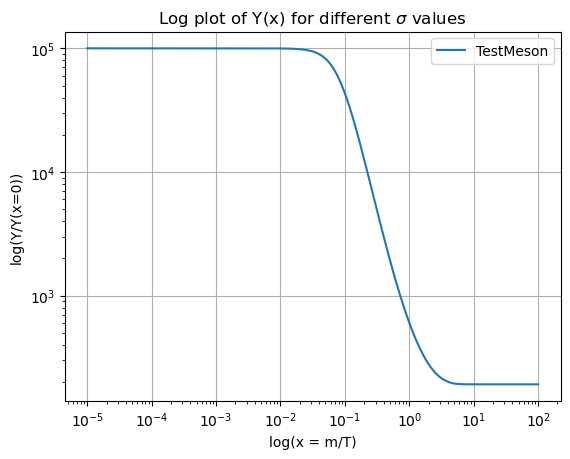

In [32]:
%run FreezeOutFunctions.ipynb
%run CrossSectionFunctions.ipynb

Y0 = [1e5]  
x_min = 1e-5 
x_max = 100
x_span = (x_min, x_max)
x_eval = np.geomspace(x_min, x_max, 5000)

# THE STRING ENCLOSED WITHIN THE "" IS TELLING THE CODE WHAT RATIO TO USE REGARDLESS OF WHAT VARIABLE YOU PASS THROUGH NEXT
sigma_values = {
    "TestMeson": Sigma_Meson,
    #"TestBaryon": Sigma_Baryon
}

for particle, sigma_value in sigma_values.items():
    sol = solve_ivp(lambda x, Y: dYdx(x, Y, particle), x_span, Y0, t_eval=x_eval)
    print(particle)
    
    # Number of frozen-out DM particles
    Y_frozen = sol.y[0, -1]
    print(f'Frozen-out Y(x) for {particle} = {Y_frozen}')
    print(f'Cross section of {particle} = {sigma_value}')
    
    plt.plot(sol.t, sol.y[0], label=f'{particle}')
    
# Plot configurations
plt.yscale('log')  
plt.xscale('log')  
plt.xlabel('log(x = m/T)')
plt.ylabel('log(Y/Y(x=0))')
plt.title('Log plot of Y(x) for different $\sigma$ values')
plt.legend()
plt.grid(True)
#plt.savefig('DifferentSigmaSValues.png', facecolor='w')

plt.show()

<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
C:\Users\press\AppData\Local\Temp\ipykernel_916\1078436198.py:32: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Log plot of Y(x) for different $\sigma$ values')
C:\Users\press\AppData\Local\Temp\ipykernel_916\3980838.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  return (1 / (8 * mass**4 * T * kn(2, mass / T))) * integral_result
C:\Users\press\AppData\Local\Temp\ipykernel_916\3980838.py:14: RuntimeWarning: invalid value encountered in scalar multiply
  return (1 / (8 * mass**4 * T * kn(2, mass / T))) * integral_result


TestMeson
[[100000.         100000.         100000.         ...    191.60522931
     191.60522931    191.60522931]]
Frozen-out Y(x) for TestMeson = 191.6052293084017


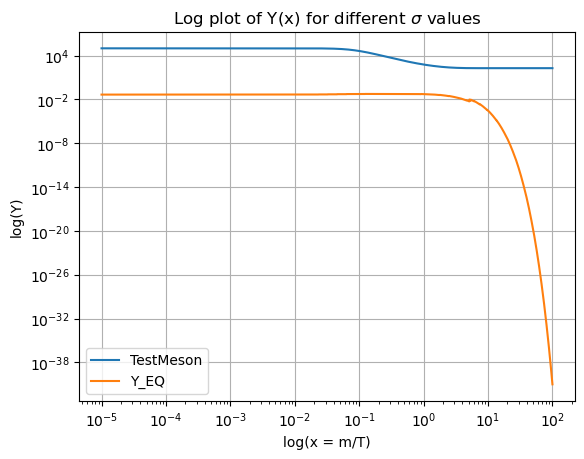

In [33]:
%run FreezeOutFunctions.ipynb
%run CrossSectionFunctions.ipynb

Y0 = [1e5]  
x_min = 1e-5 
x_max = 100
x_span = (x_min, x_max)
x_eval = np.geomspace(x_min, x_max, 5000)

sigma_values = ["TestMeson"]#, "TestBaryon", "TestMeson2", "TestMeson3", "TestMeson4", "TestMeson5"]

for particle in sigma_values:
    sol = solve_ivp(lambda x, Y: dYdx(x, Y, particle), x_span, Y0, t_eval=x_eval)
    print(particle)
    
    # Number of frozen-out DM particles
    print(sol.y)
    Y_frozen = sol.y[0, -1]
    print(f'Frozen-out Y(x) for {particle} = {Y_frozen}')
    #print(f'Cross section of {particle} = {sigma_value}')

    plt.plot(sol.t, sol.y[0], label=f'{particle}')

    Y = Y_EQ(x_eval, particle)  # Use x_eval instead of x_span
    plt.plot(x_eval, Y, label="Y_EQ")

# Plot configurations
plt.yscale('log')  
plt.xscale('log')  
plt.xlabel('log(x = m/T)')
plt.ylabel('log(Y)')
plt.title('Log plot of Y(x) for different $\sigma$ values')
plt.legend()
plt.grid(True)
plt.savefig('DifferentSigmaSValues.png', facecolor='w')

plt.show()

In [ ]:
"""
sigma_values = [Sigma_SC_NeutralPion, Sigma_SC_NeutralKaon]

for sigma_value in sigma_values:
    sigma_name = get_variable_name(sigma_value, globals())
    sol = solve_ivp(lambda x, Y: dYdx(x, Y, sigma_value), x_span, Y0, t_eval=x_eval)
        
    # Number of frozen-out dm particles
    Y_frozen = sol.y[0, -1]
    print(f'Frozen-out Y(x) for {sigma_name} = {sigma_value}: {Y_frozen}')
    
    plt.plot(sol.t, sol.y[0], label=f'{sigma_name} = {sigma_value}')
"""
print(Test_meson)

Text(0.5, 1.0, 'Y_eq vs x for different Y_eq formulas')

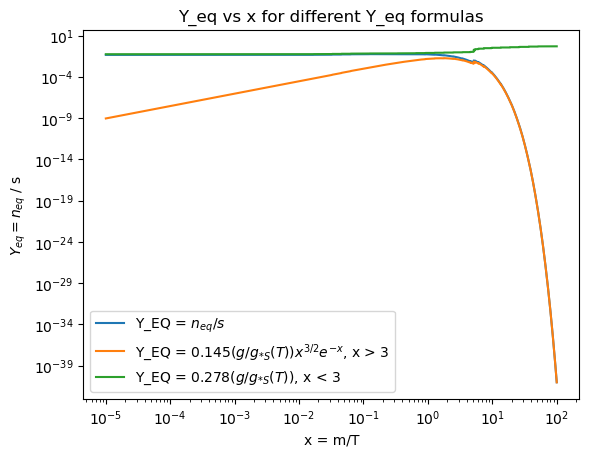

In [53]:
%run CrossSectionFunctions.ipynb

arr = []
arr2 = []
arr3 = []


for x in x_eval:
    y = Y_EQ(x, 'TestMeson')
    arr.append(y)


for x in x_eval:
    z = Y_EQ_GT3(x, 'TestMeson')
    arr2.append(z)

for x in x_eval:
    w = Y_EQ_LT3(x, 'TestMeson')
    arr3.append(w)


plt.xscale('log')
plt.plot(x_eval, arr, label = 'Y_EQ = $n_{eq}/s$')
plt.plot(x_eval, arr2, label = 'Y_EQ = $0.145(g/g_{* S}(T))x^{3/2}e^{-x}$, x > 3')
plt.plot(x_eval,arr3, label = 'Y_EQ = $0.278(g/g_{*S}(T))$, x < 3')
plt.ylabel('$Y_{eq} = n_{eq}$ / s')
plt.xlabel('x = m/T')
plt.yscale('log')
plt.legend()
plt.title('Y_eq vs x for different Y_eq formulas')

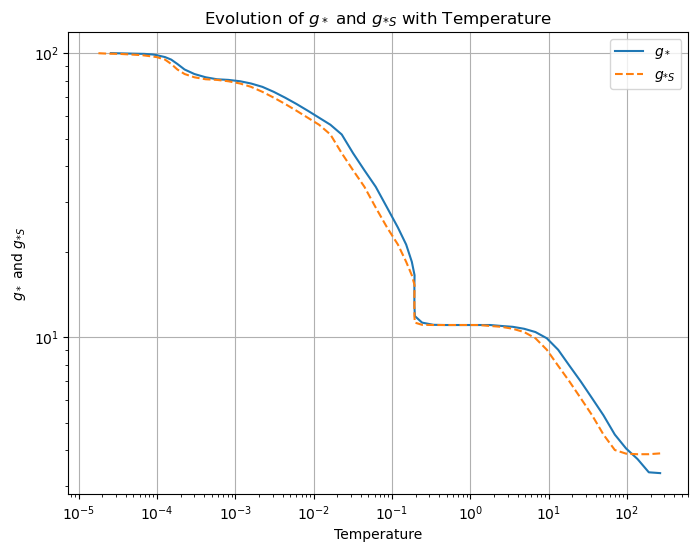

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
Gstar_df = pd.read_csv("Gstar.csv")
GstarS_df = pd.read_csv("GstarS.csv")

# Convert to dictionaries while preserving order
Gstar = dict(zip(Gstar_df.iloc[:, 0], Gstar_df.iloc[:, 1]))
GstarS = dict(zip(GstarS_df.iloc[:, 0], GstarS_df.iloc[:, 1]))

# Extract temperature values and corresponding function values in original order
temps_Gstar = Gstar_df.iloc[:, 0].values  # Keep order from CSV
values_Gstar = np.flip(Gstar_df.iloc[:, 1].values)  

temps_GstarS = GstarS_df.iloc[:, 0].values  # Keep order from CSV
values_GstarS = np.flip(GstarS_df.iloc[:, 1].values)  

# Plot the functions
plt.figure(figsize=(8, 6))
plt.plot(temps_Gstar, values_Gstar, label="$g_*$", linestyle="-")
plt.plot(temps_GstarS, values_GstarS, label="$g_{*S}$", linestyle="--")
plt.xscale('log')

plt.yscale('log')

# Labels and title
plt.xlabel("Temperature")
plt.ylabel("$g_*$ and $g_{*S}$")
plt.title("Evolution of $g_*$ and $g_{*S}$ with Temperature")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
